In [145]:
import os,sys
sys.path.append('/home/ubuntu/hacking/projects/deep-mediation/keras-vis')
sys.path.append('/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/src')

In [217]:
import utils,build_model
import numpy as np
from keras.models import load_model
import nibabel as nib
import create_dataset,utils
import pandas as pd
from nilearn.image import resample_img,concat_imgs,load_img,resample_to_img,threshold_img,smooth_img,mean_img,index_img
from nilearn.plotting import view_img
import keras
from nilearn.datasets import MNI152_FILE_PATH

In [147]:
from vis.visualization import visualize_cam 
from vis.visualization import visualize_saliency
from vis.utils import utils as vis_utils

In [148]:
data_path = '/home/ubuntu/hacking/data/stephan-data-ni-files'
model_to_use = '/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/results/deep/deep-iter-4-run-0.h5'
img_to_use = '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S860_OC1339_zs.nii'

In [97]:
model = load_model(model_to_use)
model = model.layers[-2]

In [12]:
dataset = create_dataset.generate_dataset(data_path,test_data_size=0.30)
train_rate,train_temp,train_imgs_list,flat_train_rate,flat_train_rate_zs = utils.get_rate_temp_img(dataset,subjs='train_subjs')
test_rate,test_temp,test_imgs_list,flat_test_rate,flat_test_rate_zs = utils.get_rate_temp_img(dataset,subjs='test_subjs')


These are the studies to use ['NSF', 'BMRK3', 'BMRK4', 'IE', 'ILCP', 'EXP', 'SCEBL']
This is the test study BMRK5 


In [13]:
train_imgs_list[0:5],test_imgs_list[0:5]

(['/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj1_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj2_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj3_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj4_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj5_zs.nii'],
 ['/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S850_OC1300_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S853_OC1307_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S860_OC1339_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S865_OC1328_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S872_OC1337_zs.nii'])

In [14]:
print("Reading testing images...")
test_imgs = utils.concat_imgs(test_imgs_list)
print("Smoothing testing images...")
test_imgs = smooth_img(test_imgs, fwhm=[4,4,4]) #in mm 
test_imgs = np.rollaxis(test_imgs.get_fdata(), 3, 0)[...,None]

Reading testing images...
Smoothing testing images...


In [15]:
def get_model(model_to_use):
    model_with_gpu = load_model(model_to_use)
    model = model_with_gpu.layers[-2]
    return model
def get_nifti_params(input_img):
    affine = input_img.affine
    hdr = input_img.header
    return affine,hdr
def get_nifti_image(array,affine,header):
    nii_image = nib.Nifti1Image(array, affine, header)
    return nii_image

In [184]:
image_to_use = MNI152_FILE_PATH
input_img = load_img(img_to_use)
affine,hdr = get_nifti_params(input_img)
input_img = input_img.get_fdata()
input_img = np.rollaxis(input_img, 3,0)[...,None]


In [49]:
layer_idx = vis_utils.find_layer_idx(model, 'PainPrediction')
penultimate_layer = vis_utils.find_layer_idx(model, 'conv3d_15')

In [50]:
layer_idx,penultimate_layer

(50, 41)

In [51]:
test_imgs[0:1,:].shape

(1, 91, 109, 91, 1)

In [41]:
visualize_saliency?

In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Allimages (InputLayer)          (None, 91, 109, 91,  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 91, 109, 91,  0           Allimages[0][0]                  
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 91, 109, 91,  0           Allimages[0][0]                  
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1486921     lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [52]:
grads = visualize_cam(model, layer_idx, filter_indices=None, seed_input=test_imgs)                

AttributeError: Layer model_1 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [72]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [73]:
layer_dict

{'Allimages': <keras.engine.input_layer.InputLayer at 0x7fbf97cd7048>,
 'PainPrediction': <keras.layers.merge.Concatenate at 0x7fbf97c722b0>,
 'lambda_1': <keras.layers.core.Lambda at 0x7fbf97cd70b8>,
 'lambda_2': <keras.layers.core.Lambda at 0x7fbf97cd7390>,
 'model_1': <keras.engine.training.Model at 0x7fbf97cd71d0>}

In [113]:
layer_name ='PainPrediction'

In [114]:
layer_output = layer_dict[layer_name].output

In [99]:
from keras import backend as K
fn = K.function([model.get_input_at(1)], [layer_output])

In [78]:
inp= test_imgs[0:2,:]

In [96]:
layer_output

<tf.Tensor 'PainPrediction_7/concat:0' shape=(?, 1) dtype=float32>

In [115]:
# Specify a function that visualized the layers
import matplotlib.pyplot as plt
def show_activation(layer_name,X_train):
    
    layer_output = layer_dict[layer_name].output

    fn = K.function([model.get_input_at(0)], [layer_output])
    
    inp = X_train#[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations, 8 filters per row
    plt.figure(figsize=(16,8))
    nFilters = this_hidden.shape[-1]
    nColumn = 8 if nFilters >= 8 else nFilters
    for i in range(nFilters):
        plt.subplot(nFilters / nColumn, nColumn, i+1)
        plt.imshow(this_hidden[0,:,:,i], cmap='magma', interpolation='nearest')
        plt.axis('off')
    
    return this_hidden

In [125]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Allimages (InputLayer)          (None, 91, 109, 91,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 91, 109, 91,  224         Allimages[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 91, 109, 91,  32          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 91, 109, 91,  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

In [126]:
model.layers[0].input

<tf.Tensor 'Allimages_10:0' shape=(?, 91, 109, 91, 1) dtype=float32>

In [130]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[-1].output])
layer_output = get_3rd_layer_output([x])[0]

In [136]:
test_imgs[0:1].shape

(1, 91, 109, 91, 1)

In [138]:
get_3rd_layer_output([test_imgs[0:1]])

[array([[0.09640943]], dtype=float32)]

In [ ]:

decoder_conv_tran_layer1 = Conv3DTranspose(filters=4, kernel_size = (3, 3, 3), strides=(2,2,2), 
                    padding=paddingType,kernel_regularizer=regularizers.l2(regAmount), 
                    name="decoder_conv_tran_1")(decoder_reshape)

In [213]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

final_conv_layer = get_output_layer(model, "conv3d_3")
get_output = K.function([model.layers[0].input], 
                        [final_conv_layer.output, model.layers[-1].output])
[conv_outputs, predictions] = get_output([test_imgs[0:1]])

In [216]:
conv_outputs_nii = get_nifti_image(conv_outputs[0],affine,hdr)
conv_outputs_nii.shape

(91, 109, 91, 8)

In [227]:
meanImg = mean_img(conv_outputs_nii)
threshold_percentile_img = threshold_img(meanImg, threshold='97%', copy=False)

/home/ubuntu/anaconda3/envs/myclone/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



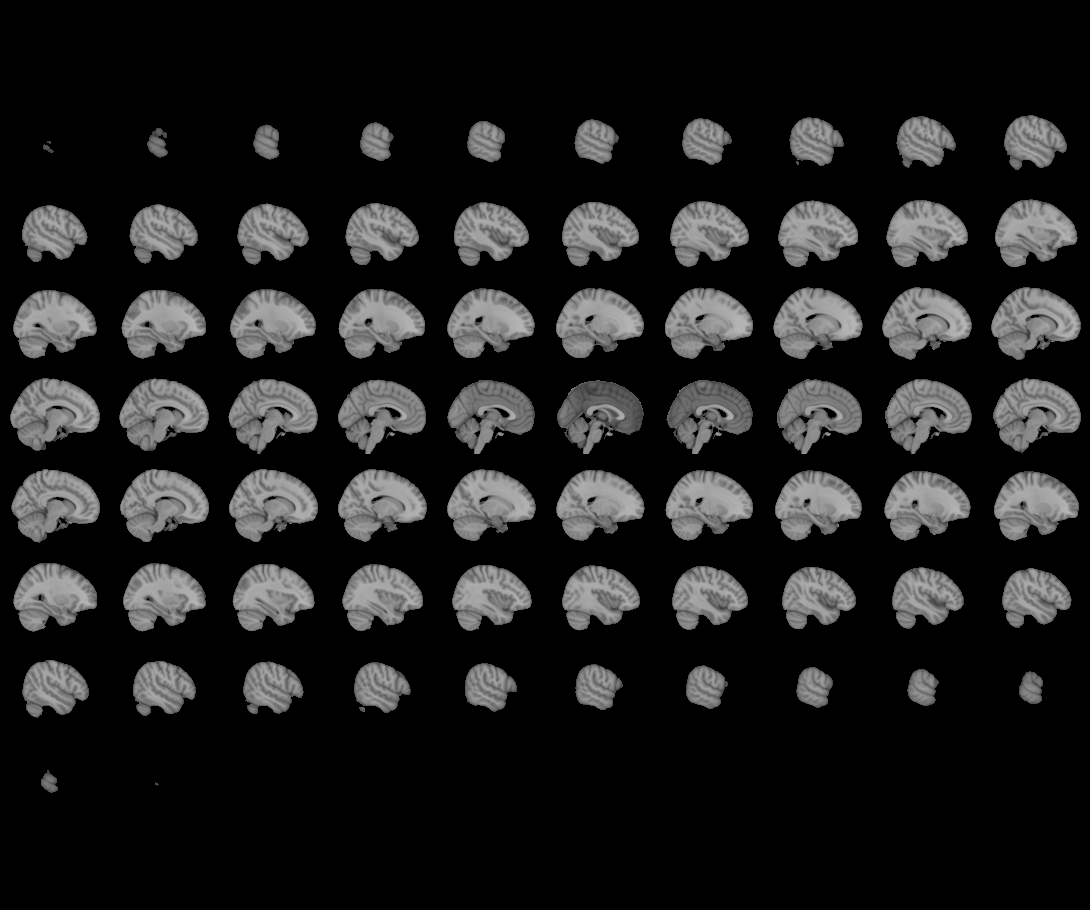
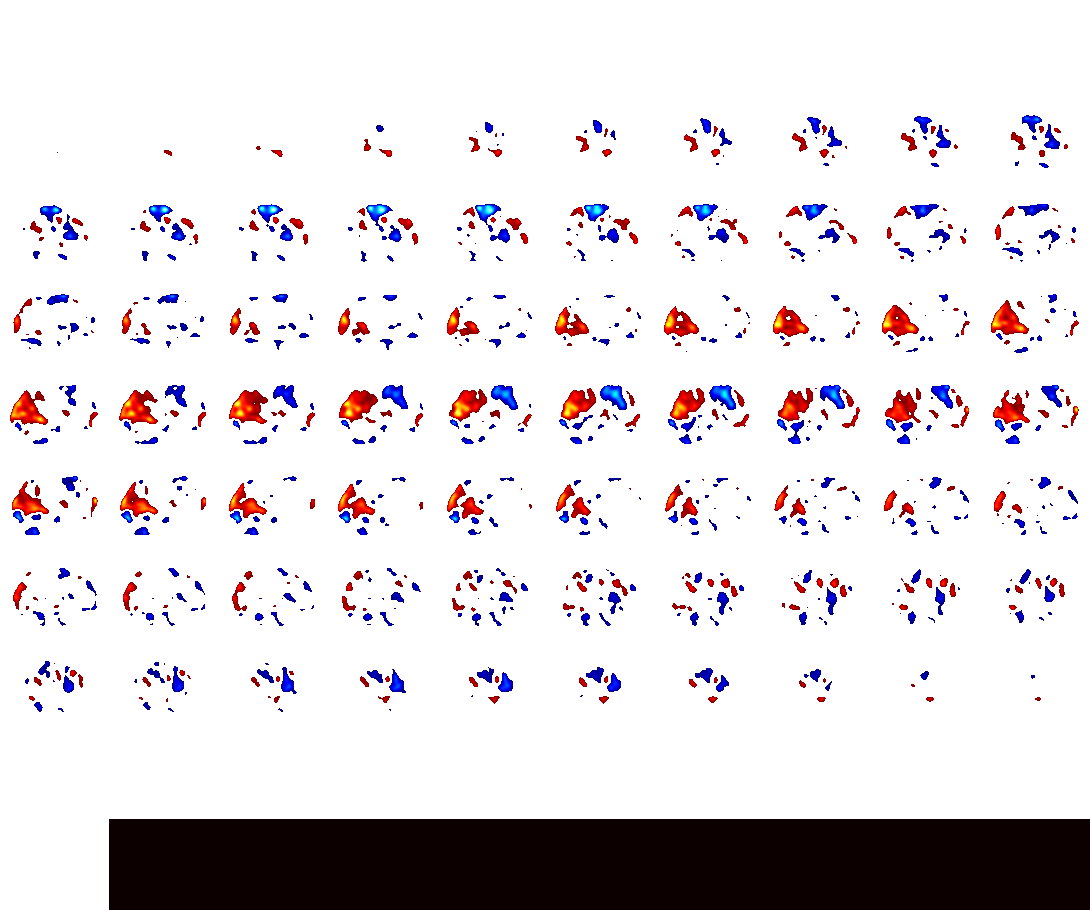

In [228]:
view = view_img(threshold_percentile_img)
view

In [132]:
test_imgs.shape

(2596, 91, 109, 91, 1)

In [142]:
conv_outputs.shape

(1, 91, 109, 91, 8)